# Debug Qiskit Runtime jobs
{/* cspell:ignore ZIIIII, IZIIII,IIZIII, IIIZII, IIIIZI, IIIIIZ, rdiff */}
<LegacyContent>
<Admonition type="note">
This documentation is relevant to IBM Quantum&reg; Platform Classic. If you need the newer version, go to the new [IBM Quantum Platform documentation.](https://quantum.cloud.ibm.com/docs/guides/debug-qiskit-runtime-jobs)
</Admonition>
</LegacyContent>
<CloudContent>
<Admonition type="note">
This documentation is relevant to the new IBM Quantum&reg; Platform. If you need the previous version, return to the [IBM Quantum Platform Classic documentation.](https://docs.quantum.ibm.com/guides/debug-qiskit-runtime-jobs)
</Admonition>
</CloudContent>

Before submitting a resource-intensive Qiskit Runtime workload to execute on hardware, you can use the Qiskit Runtime [`Neat` (Noisy Estimator Analyzer Tool)](/api/qiskit-ibm-runtime/debug-tools-neat#neat) class to verify that your Estimator workload is set up correctly, is likely to return  accurate results, uses the most appropriate options for the specified problem, and more.

`Neat` Cliffordizes the input circuits for efficient simulation, while retaining its structure and depth. Clifford circuits suffer similar levels of noise and are a good proxy for studying the original circuit of interest.


The following examples illustrate situations where `Neat` can be a useful resource.

<LegacyContent>
First, import the relevant packages and [authenticate to the Qiskit Runtime service.](/guides/setup-channel)
</LegacyContent>
<CloudContent>
First, import the relevant packages and [authenticate to the Qiskit Runtime service.](/guides/cloud-setup)
</CloudContent>

## Prepare the environment

In [1]:
import numpy as np
import random

from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.debug_tools import Neat

from qiskit_aer.noise import NoiseModel, depolarizing_error

In [2]:
# Choose the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

# Generate a preset pass manager
# This will be used to convert the abstract circuit to an equivalent Instruction Set Architecture (ISA) circuit.
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Set the random seed
random.seed(10)

## Initialize a target circuit

Consider a six-qubit circuit that has the following properties:

* Alternates between random `RZ` rotations and layers of `CNOT` gates.
* Has a mirror structure, that is, it applies a unitary `U` followed by its inverse.

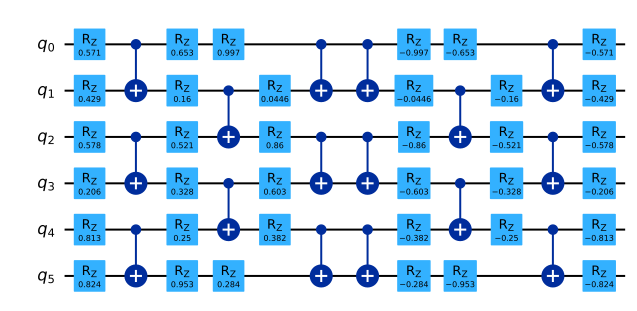

In [3]:
def generate_circuit(n_qubits, n_layers):
    r"""
    A function to generate a pseudo-random a circuit with ``n_qubits`` qubits and
    ``2*n_layers`` entangling layers of the type used in this notebook.
    """
    # An array of random angles
    angles = [
        [random.random() for q in range(n_qubits)] for s in range(n_layers)
    ]

    qc = QuantumCircuit(n_qubits)
    qubits = list(range(n_qubits))

    # do random circuit
    for layer in range(n_layers):
        # rotations
        for q_idx, qubit in enumerate(qubits):
            qc.rz(angles[layer][q_idx], qubit)

        # cx gates
        control_qubits = (
            qubits[::2] if layer % 2 == 0 else qubits[1 : n_qubits - 1 : 2]
        )
        for qubit in control_qubits:
            qc.cx(qubit, qubit + 1)

    # undo random circuit
    for layer in range(n_layers)[::-1]:
        # cx gates
        control_qubits = (
            qubits[::2] if layer % 2 == 0 else qubits[1 : n_qubits - 1 : 2]
        )
        for qubit in control_qubits:
            qc.cx(qubit, qubit + 1)

        # rotations
        for q_idx, qubit in enumerate(qubits):
            qc.rz(-angles[layer][q_idx], qubit)

    return qc


# Generate a random circuit
qc = generate_circuit(6, 3)
# Convert the abstract circuit to an equivalent ISA circuit.
isa_qc = pm.run(qc)

qc.draw("mpl", idle_wires=0)

Choose single-Pauli `Z` operators as observables and use them to initialize the primitive unified blocs (PUBs).

In [4]:
# Initialize the observables
obs = ["ZIIIII", "IZIIII", "IIZIII", "IIIZII", "IIIIZI", "IIIIIZ"]
print(f"Observables: {obs}")

# Map the observables to the backend's layout
isa_obs = [SparsePauliOp(o).apply_layout(isa_qc.layout) for o in obs]

# Initialize the PUBs, which consist of six-qubit circuits with `n_layers` 1, ..., 6
all_n_layers = [1, 2, 3, 4, 5, 6]

pubs = [(pm.run(generate_circuit(6, n)), isa_obs) for n in all_n_layers]

Observables: ['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ']


## Cliffordize the circuits

The previously defined PUB circuits are not Clifford, which makes them difficult to simulate classically. However, you can use the `Neat` [`to_clifford`](/api/qiskit-ibm-runtime/debug-tools-neat#to_clifford) method to map them to Clifford circuits for more efficient simulation.  The [`to_clifford`](/api/qiskit-ibm-runtime/debug-tools-neat#to_clifford) method is a wrapper around the [`ConvertISAToClifford`](/api/qiskit-ibm-runtime/transpiler-passes-convert-isa-to-clifford) transpiler pass, which can also be used independently. In particular, it replaces non-Clifford single-qubit gates in the original circuit with Clifford single-qubit gates, but it does not mutate the two-qubit gates, number of qubits, or circuit depth.

See [Efficient simulation of stabilizer circuits with Qiskit Aer primitives](/guides/simulate-stabilizer-circuits) for more information about Clifford circuit simulation.

First, initialize `Neat`.

In [5]:
# You could specify a custom `NoiseModel` here. If `None`, `Neat`
# pulls the noise model from the given backend
noise_model = None

# Initialize `Neat`
analyzer = Neat(backend, noise_model)

Next, Cliffordize the PUBs.

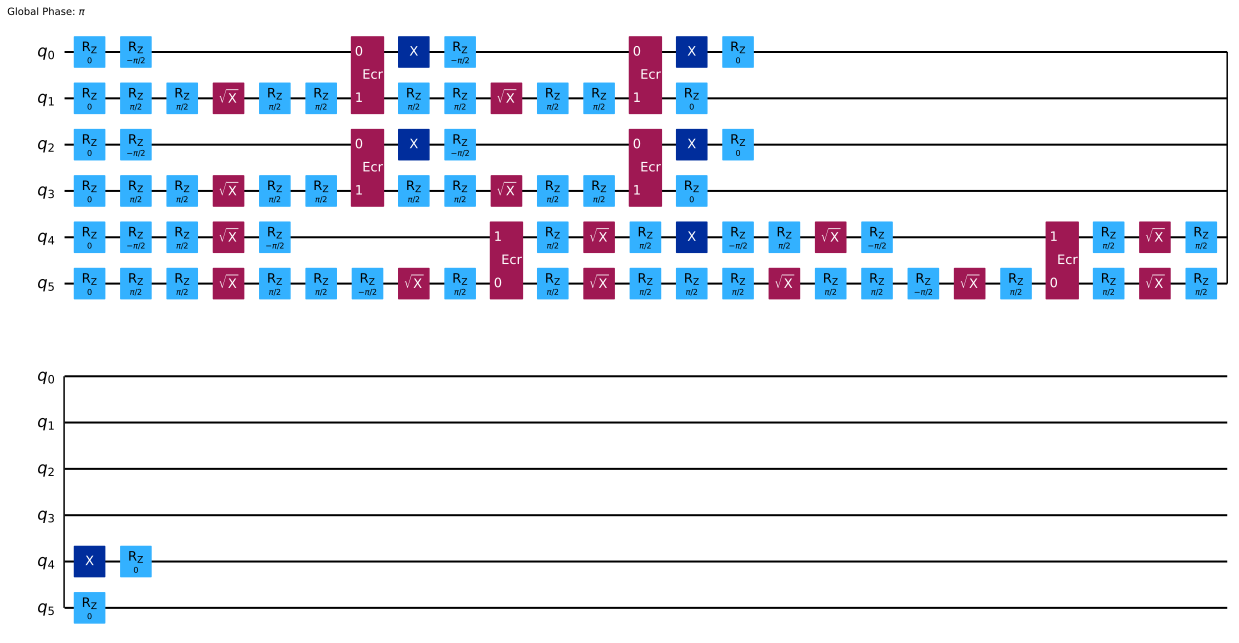

In [6]:
clifford_pubs = analyzer.to_clifford(pubs)

clifford_pubs[0].circuit.draw("mpl", idle_wires=0)

## Application 1: Analyze the impact of noise on the circuit outputs

This example shows how to use `Neat` to study the impact of different noise models on PUBs as a function of circuit depth by running simulations in both ideal ([`ideal_sim`](/api/qiskit-ibm-runtime/debug-tools-neat#ideal_sim)) and noisy ([`noisy_sim`](/api/qiskit-ibm-runtime/debug-tools-neat#noisy_sim)) conditions. This can be useful to set up expectations on the quality of the experimental results before running a job on a QPU. To learn more about noise models, see [Exact and noisy simulation with Qiskit Aer primitives.](/guides/simulate-with-qiskit-aer#exact-and-noisy-simulation-with-qiskit-aer-primitives)

The simulated results support mathematical operations, and can therefore be compared with each other (or with experimental results) to calculate figures of merit.

Begin by performing ideal and noisy classical simulations.

In [7]:
# Perform a noiseless simulation
ideal_results = analyzer.ideal_sim(clifford_pubs)
print(f"Ideal results:\n {ideal_results}\n")

# Perform a noisy simulation with the backend's noise model
noisy_results = analyzer.noisy_sim(clifford_pubs)
print(f"Noisy results:\n {noisy_results}\n")

Ideal results:
 NeatResult([NeatPubResult(vals=array([1., 1., 1., 1., 1., 1.])), NeatPubResult(vals=array([1., 1., 1., 1., 1., 1.])), NeatPubResult(vals=array([1., 1., 1., 1., 1., 1.])), NeatPubResult(vals=array([1., 1., 1., 1., 1., 1.])), NeatPubResult(vals=array([1., 1., 1., 1., 1., 1.])), NeatPubResult(vals=array([1., 1., 1., 1., 1., 1.]))])



Noisy results:
 NeatResult([NeatPubResult(vals=array([0.96679688, 0.95898438, 0.98828125, 0.9921875 , 0.98046875,
       0.984375  ])), NeatPubResult(vals=array([0.95507812, 0.96289062, 0.94140625, 0.97265625, 0.94921875,
       0.97460938])), NeatPubResult(vals=array([0.8828125 , 0.88476562, 0.92382812, 0.9453125 , 0.95898438,
       0.98046875])), NeatPubResult(vals=array([0.8671875 , 0.84960938, 0.87695312, 0.91601562, 0.92382812,
       0.95703125])), NeatPubResult(vals=array([0.8046875 , 0.796875  , 0.81054688, 0.88671875, 0.89453125,
       0.94140625])), NeatPubResult(vals=array([0.765625  , 0.765625  , 0.796875  , 0.84375   , 0.875     ,
       0.93945312]))])



Next, apply mathematical operations to compute the absolute difference. The remainder of the guide uses the absolute difference as a figure of merit to compare ideal results with noisy or experimental results, but similar figures of merit can be set up.

The absolute difference shows that the impact of noise grows with the circuits' sizes.

In [8]:
# Figure of merit: Absolute difference
def rdiff(res1, re2):
    r"""The absolute difference between `res1` and re2`.

    --> The closer to `0`, the better.
    """
    d = abs(res1 - re2)
    return np.round(d.vals * 100, 2)


for idx, (ideal_res, noisy_res) in enumerate(
    zip(ideal_results, noisy_results)
):
    vals = rdiff(ideal_res, noisy_res)

    # Print the mean absolute difference for the observables
    mean_vals = np.round(np.mean(vals), 2)
    print(
        f"Mean absolute difference between ideal and noisy results for circuits with {all_n_layers[idx]} layers:\n  {mean_vals}%\n"
    )

Mean absolute difference between ideal and noisy results for circuits with 1 layers:
  2.15%

Mean absolute difference between ideal and noisy results for circuits with 2 layers:
  4.07%

Mean absolute difference between ideal and noisy results for circuits with 3 layers:
  7.06%

Mean absolute difference between ideal and noisy results for circuits with 4 layers:
  10.16%

Mean absolute difference between ideal and noisy results for circuits with 5 layers:
  14.42%

Mean absolute difference between ideal and noisy results for circuits with 6 layers:
  16.89%



You can follow these rough and simplified guidelines to improve circuits of this type:

- If the mean absolute difference is greater than 90%, mitigation will likely not help.
- If the mean absolute difference is less than 90%, [Probabilistic Error Amplification (PEA)](/guides/error-mitigation-and-suppression-techniques#probabilistic-error-amplification-pea) will likely be able to improve the results.
- If the mean absolute difference is less than 80%, [ZNE with gate folding](/guides/error-mitigation-and-suppression-techniques#zero-noise-extrapolation-zne) will also likely be able to improve the results.

Because all of the absolute differences above are less than 90%, applying PEA to the original circuit will hopefully improve the quality of its results.

You can specify different noise models in the analyzer. The following example performs the same test but adds a custom noise model.

In [9]:
# Set up a noise model with strength 0.02 on every two-qubit gate
noise_model = NoiseModel()
for qubits in backend.coupling_map:
    noise_model.add_quantum_error(
        depolarizing_error(0.02, 2), ["ecr", "cx"], qubits
    )

# Update the analyzer's noise model
analyzer.noise_model = noise_model

# Perform a noiseless simulation
ideal_results = analyzer.ideal_sim(clifford_pubs)

# Perform a noisy simulation with the backend's noise model
noisy_results = analyzer.noisy_sim(clifford_pubs)

# Compare the results
for idx, (ideal_res, noisy_res) in enumerate(
    zip(ideal_results, noisy_results)
):
    values = rdiff(ideal_res, noisy_res)

    # Print the mean absolute difference for the observables
    mean_values = np.round(np.mean(values), 2)
    print(
        f"Mean absolute difference between ideal and noisy results for circuits with {all_n_layers[idx]} layers:\n  {mean_values}%\n"
    )

Mean absolute difference between ideal and noisy results for circuits with 1 layers:
  3.32%

Mean absolute difference between ideal and noisy results for circuits with 2 layers:
  8.53%

Mean absolute difference between ideal and noisy results for circuits with 3 layers:
  13.35%

Mean absolute difference between ideal and noisy results for circuits with 4 layers:
  17.74%

Mean absolute difference between ideal and noisy results for circuits with 5 layers:
  25.94%

Mean absolute difference between ideal and noisy results for circuits with 6 layers:
  28.29%



As shown, given a noise model, you can try to quantify the impact of noise on the (Cliffordized version of the) PUBs of interest before running them on a QPU.

## Application 2: Benchmark different strategies

This example uses `Neat` to help identify the best options for your PUBs. To do so, consider running an estimation problem with PEA, which cannot be simulated with `qiskit_aer`. You can use `Neat` to help determine which noise amplification factors will work best, then use those factors when running the original experiment on a QPU.

In [10]:
# Generate a circuit with six qubits and six layers
isa_qc = pm.run(generate_circuit(6, 3))

# Use the same observables as previously
pubs = [(isa_qc, isa_obs)]
clifford_pubs = analyzer.to_clifford(pubs)

In [11]:
noise_factors = [
    [1, 1.1],
    [1, 1.1, 1.2],
    [1, 1.5, 2],
    [1, 1.5, 2, 2.5, 3],
    [1, 4],
]

In [12]:
# Run the PUBs on a QPU
estimator = Estimator(backend)
estimator.options.default_shots = 100000
estimator.options.twirling.enable_gates = True
estimator.options.twirling.enable_measure = True
estimator.options.twirling.shots_per_randomization = 100
estimator.options.resilience.measure_mitigation = True
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.amplifier = "pea"

jobs = []
for factors in noise_factors:
    estimator.options.resilience.zne.noise_factors = factors
    jobs.append(estimator.run(clifford_pubs))

results = [job.result() for job in jobs]

In [13]:
# Perform a noiseless simulation
ideal_results = analyzer.ideal_sim(clifford_pubs)

In [14]:
# Look at the mean absolute difference to quickly tell the best choice for your options
for factors, res in zip(noise_factors, results):
    d = rdiff(ideal_results[0], res[0])
    print(
        f"Mean absolute difference for factors {factors}:\n  {np.round(np.mean(d), 2)}%\n"
    )

Mean absolute difference for factors [1, 1.1]:
  6.22%

Mean absolute difference for factors [1, 1.1, 1.2]:
  3.48%

Mean absolute difference for factors [1, 1.5, 2]:
  1.57%

Mean absolute difference for factors [1, 1.5, 2, 2.5, 3]:
  1.63%

Mean absolute difference for factors [1, 4]:
  1.37%



The result with the smallest difference suggests which options to choose.

## Next steps

<Admonition type="tip" title="Recommendations">
    - Learn about [Exact and noisy simulation with Qiskit Aer primitives.](/guides/simulate-with-qiskit-aer)
    - Learn about [available Qiskit Runtime options.](/guides/runtime-options-overview)
    - Learn about [Error mitigation and suppression techniques.](/guides/error-mitigation-and-suppression-techniques)
    - Visit the [Transpile with pass managers](transpile-with-pass-managers) topic.
    - Learn [how to transpile circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) as part of Qiskit Patterns workflows using Qiskit Runtime.
    - Review the [Debugging tools API documentation.](/api/qiskit-ibm-runtime/debug-tools)
</Admonition>